(sec:SIRSmallPop)=
# SIR outbreak sizes in small populations

Now we consider an SIR disease spreading in a small population of $N$ individuals where even at early time $N$ is not large enough that we can assume each transmission goes to a new recipient.  The assumptions leading to a Galton-Watson process break down in this limit.  However, perhaps remarkably PGFs still play a role in the calculation of the outbreak size distribution.



## Illustrative simulations:

We look at the same simulations we did earlier, but for smaller population sizes.

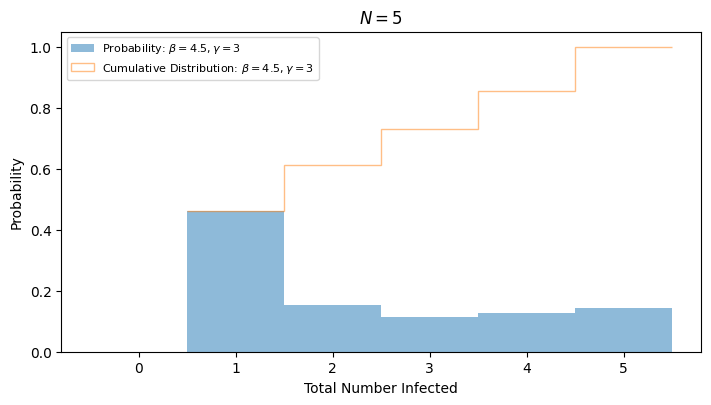

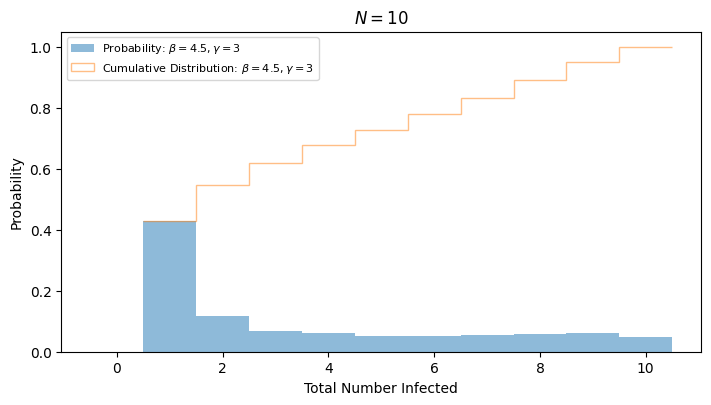

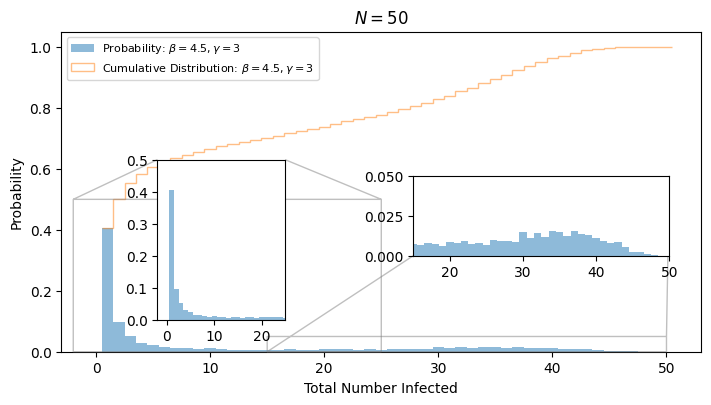

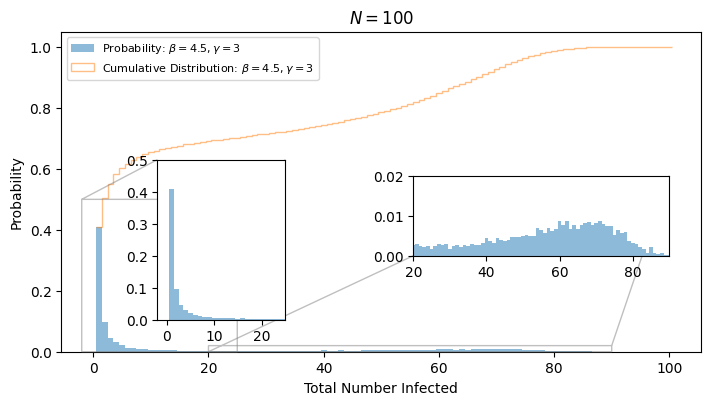

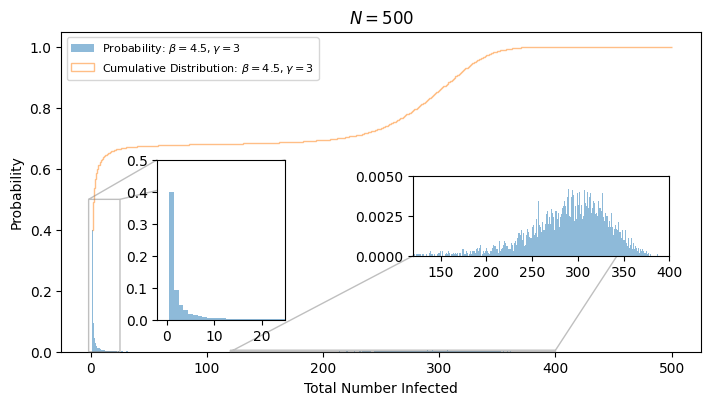

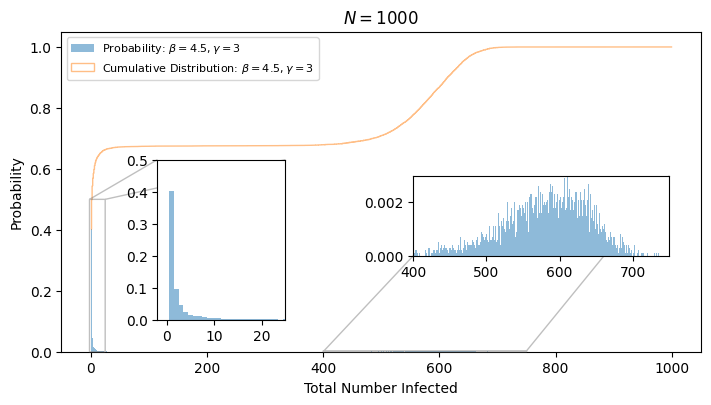

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from AMSI_2026_PGF_tools import Gillespie_SIR_model  #same algorithm as in previous section

def simulate_and_plot_SIR_final_size(N, R0=1.5, gammas=(3,), numsims = 10000, xlim1 = (-2,25), xlim2 = (400,750), ylim1=(0,0.5), ylim2 = (0,0.003), insets = False):

    fig = plt.figure(figsize = (8,4))
    mainax = fig.add_axes([0.1,0.1,0.8,0.8])
    if insets:
        inset_ax1 = mainax.inset_axes([0.15,0.1,0.2,0.5], xlim=xlim1, ylim=ylim1)
        inset_ax2 = mainax.inset_axes([0.55,0.3,0.4,0.25], xlim=xlim2, ylim=ylim2)

    for gamma in gammas:
        beta = R0 * gamma
        I0 = 1
        final_sizes = []
        for _ in range(numsims):
            t, S, I, R = Gillespie_SIR_model(N-I0, I0, 0, beta, gamma)
            final_sizes.append(R[-1])
        final_sizes = np.array(final_sizes)
        mainax.hist(final_sizes, bins=-0.5+np.arange(N+2), density=True, alpha=0.5, label=f'Probability: $\\beta={beta}, \\gamma={gamma}$')
        mainax.hist(final_sizes, bins=-0.5+np.arange(N+2), density=True, cumulative=True, alpha=0.5, histtype='step')
        if insets:
            inset_ax2.hist(final_sizes, bins = -0.5+np.arange(N+1), density=True, alpha=0.5, label=f'$\\beta={beta}, \\gamma={gamma}$')
            inset_ax1.hist(final_sizes, bins = -0.5+np.arange(N+1), density=True, alpha=0.5, label=f'$\\beta={beta}, \\gamma={gamma}$')


        #modifying cumulative dist plot followinghttps://stackoverflow.com/a/50711003/2966723
        poly = mainax.findobj(plt.Polygon)[-1] 
        vertices = poly.get_path().vertices

        # Keep everything above y == 0. You can define this mask however
        # you need, if you want to be more careful in your selection.
        keep = vertices[:, 1] > 0

        # Construct new polygon from these "good" vertices
        new_poly = plt.Polygon(vertices[keep], closed=False, fill=False,
                               edgecolor=poly.get_edgecolor(),
                               linewidth=poly.get_linewidth(), 
                               label = f'Cumulative Distribution: $\\beta={beta}, \\gamma={gamma}$')
        poly.set_visible(False)
        mainax.add_artist(new_poly)
        plt.draw()
    if insets:
        mainax.indicate_inset_zoom(inset_ax1)
        mainax.indicate_inset_zoom(inset_ax2)
    plt.xlabel('Total Number Infected')
    plt.ylabel('Probability')
    plt.legend(loc='upper left', fontsize=8)
    plt.title('$N={}$'.format(N))

simulate_and_plot_SIR_final_size(5, numsims = 10000)
simulate_and_plot_SIR_final_size(10, numsims = 10000)
simulate_and_plot_SIR_final_size(50, numsims = 10000, xlim1 = (-2,25), xlim2 = (15,50), ylim1=(0,0.5), ylim2=(0,0.05),insets=True)
simulate_and_plot_SIR_final_size(100, numsims = 10000, xlim1 = (-2,25), xlim2 = (20,90), ylim1=(0,0.5), ylim2 = (0,0.02), insets=True)
simulate_and_plot_SIR_final_size(500, numsims = 10000, xlim1 = (-2,25), xlim2 = (120,400), ylim1=(0,0.5), ylim2 = (0,0.005), insets=True)
simulate_and_plot_SIR_final_size(1000, numsims = 10000, insets=True)
#simulate_and_plot_SIR_final_size(10000, numsims = 10000, xlim2=(5000,6500), ylim2=(0,0.002))


## Setup
We will derive a system of $N$ equations that we can use to calculate the probability $q_\ell$ that exactly $\ell$ individuals are eventually infected by the end of an outbreak, following a single introduction.  

We will use $k$ to be the total number of transmissions an individual causes.  We assume that for each infected individual, $k$ is chosen independently from the "offspring distribution" which has PGF $\mu(x)= \sum p_k x^k$.

We assume that each time an individual transmits, the recipient is chosen randomly from the remainder of the population uniformly at random and with replacement (so $u$ may transmit to $v$ multiple times, but $u$ cannot transmit to itself).


We will number the individuals $u_1, u_2, u_3, \ldots, u_N$.  We can assume without loss of generality that infection is introduced in $u_1$.





## Conversion to a directed graph.

```{figure} Fates.png
---
width: 300px
align: right
name: fates
---
The Fates of Greek mythology determined the course of each person's life, spinning a thread and eventually cutting it.
```

Usually when we simulate infectious disease spread, we assume that who an individual transmits to is not determined until after becoming infected.  However, it will be useful for us to adopt a fatalistic interpretation.  Prior to disease introduction, for every $u_i$ it is pre-determined who $u_i$ would transmit to if ever infected.

This fatalistic approach produces identical outcomes to the usual approach.  There is no way that an outside observe can determine whether these random outcomes are chosen in advance or when they occur.  This approach comes with the benefit that we can represent the outbreak events in a static directed network and then study properties of that network.

```{prf:algorithm} Generation of directed transmission network
:label: alg-TransNet

**Inputs**

- Distribution of number of transmissions caused $p_k$
- Number of nodes

**Procedure**
1. Create $N$ nodes $u_1, \ldots, u_N$.
2. For each node $u_i$ choose $k$ from the distribution.
3. Assign $k$ directed edges from $u_i$ to nodes.  Choose each recipient uniformly from the $N-1$ nodes other than $u_i$, with replacement.
```

{prf:ref}`alg-TransNet` describes how the transmission network is created.  In this network, an edge from $u_i$ to $u_j$ implies that if $u_i$ is ever infected, it will transmit to $u_j$.  If $u_j$ is susceptible when this happens then $u_j$ will become infected.  Note that an edge from $u_i$ to $u_j$ exists independently of whether there is an edge from $u_j$ to $u_i$.

To simulate an outbreak using this network, we choose the initial node and then simply follow edges out from it.  The nodes that are eventually infected if $u_1$ is the index case are the nodes that can be reached by following the directed edges in the network.

```{prf:definition} Outcomponent
:label: def-OutComponent

Given a directed network $G$ and a node $u$, the **out-component** of $u$ is the set of nodes that can be reached from $u$ by following the edges of the network in the assigned direction (including $u$).

Given a directed network $G$ and a set of nodes $X=\{u_1, \ldots, u_M\}$, the **out-component** of $X$ is the set of nodes that can be reached from any node in $X$ following the edges of the network in the assigned direction (including nodes in $X$).
```



## Derivation of the equations

We will find the outbreak size distribution using a common method of proving combinatorial identities.  We look for two different ways to answer the same question.  This gives us an equation.

In our case, the question we ask is:

*What is the probability that all edges from nodes in  $X=\{u_1, u_2, \ldots, u_M\}$ have no edges to any node in $Y=\{u_{M+1}, u_{M+2}, \ldots, u_N\}$?*

We will answer this question for $M=1, 2, \ldots, N$.

Then we ask an equivalent question:

*What is the probability that the out-component of $u_1$ is in $X$ and all other nodes in $X$ have edges only to other nodes in $X$?*

to yield $N$ equations for $q_1$, $q_2$, $\ldots$, $q_N$.

We can find one answer to this equation in a relatively straightforward way.
```{prf:lemma} 

The probability that all edges from a node $u_i \in X=\{u_1, u_2, \ldots, u_M\}$ remain within $X$ is $\mu\left(\frac{M-1}{N-1}\right)$ and the probability that all edges from all nodes in $X$ remain within $X$ is 

$$
\mathbb{P}\left[\begin{array}{c}\text{all edges from nodes in $X$}\\[-1ex]\text{go to other nodes in $X$}\end{array}\right] = \left(\mu\left(\frac{M-1}{N-1}\right)\right)^M$.
$$
```

```{prf:proof} 
To prove the single node case we note that the probability that an edge from $u_i \in X=\{u_1, u_2, \ldots, u_M\}$ reaches another node in $X$ is $(M-1)/(N-1)$ because there are $M-1$ nodes available within $X$ and $N-1$ available within all nodes (in both cases the $-1$ is due to excluding $u_i$).

If $u_i$ has $k$ edges, then the probability that all of these remain within $X$ is $\left(\frac{M-1}{N-1}\right)^k$.  Taking the average over all possible $k$, the probability all edges from $u_i$ remain within $X$ is 
$\mu\left(\frac{M-1}{N-1}\right) = \sum_k p_k \left(\frac{M-1}{N-1}\right)^k$

Now looking at keeping all edges from all $M$ nodes in $X$ to remain within $X$ we get that this probability is 

$$
\mathbb{P}\left[\begin{array}{c}\text{all edges from nodes in $X$}\\[-1ex]\text{go to other nodes in $X$}\end{array}\right] = \left(\mu\left(\frac{M-1}{N-1}\right)\right)^M
$$
```

We now show
```{prf:lemma}

The probability that the out-component of $u_1$ is contained within $X=\{u_1, \ldots, u_M\}$ and all other nodes in $X$ have edges only to nodes in $X$ is

$$
\mathbb{P}\left[\begin{array}{c}\text{the out-component of $u_1$ is in $X$}\\[-1ex]\text{and all other nodes in $X$ have edges}\\[-1ex] \text{only to other nodes in $X$}\end{array}\right] = \sum_{\ell=1}^M q_\ell \left(\mu\left(\frac{M-1}{N-1}\right)\right)^{M-\ell}\frac{\binom{M-1}{\ell-1}}{\binom{N-1}{\ell-1}}
$$
```

```{prf:proof}
To prove this we look at all possible out-component sizes for $u_1$ in the transmission network.

The probability that $u_1$ has an out-component of size $\ell$ is $q_\ell$.  The probability that the other $\ell-1$ nodes in this out-component are amongst the other $M-1$ nodes in $X$ is $\frac{\binom{M-1}{\ell-1}}{\binom{N-1}{\ell-1}}$.  So

$$
\mathbb{P}\left[\begin{array}{c} \text{$u_1$ has an out-component of size $\ell$}\\[-1ex]\text{which is contained within $X$}\end{array}\right] = q_\ell\frac{\binom{M-1}{\ell-1}}{\binom{N-1}{\ell-1}}
$$

If $u_1$ has such an out-component, the probability that the  $M-\ell$ nodes in $X \setminus \mathrm{out\text{-}component}(u_1)$ have all of their edges remaining within $X$ is $\left(\mu\left(\frac{M-1}{N-1}\right)\right)^{M-\ell}$ (following the proof of the previous lemma).

Thus, the probability that $u_1$ has an out-component of size $\ell$ which lies within $X$ and all edges from other nodes in $X$ remain within $X$ is 

$$
\mathbb{P}\left[\begin{array}{c} \text{$u_1$ has an out-component of size $\ell$}\\[-1ex]\text{which is contained within $X$ and all}\\[-1ex]\text{edges from other nodes in $X$ remain in $X$}\end{array}\right] = q_\ell \frac{\binom{M-1}{\ell-1}}{\binom{N-1}{\ell-1}}\left(\mu\left(\frac{M-1}{N-1}\right)\right)^{M-\ell}
$$

We now sum this over all possible $\ell$:

$$
\mathbb{P}\left[\begin{array}{c}\text{the out-component of $u_1$ is in $X$}\\[-1ex]\text{and all other nodes in $X$ have edges}\\[-1ex] \text{only to other nodes in $X$}\end{array}\right] = \sum_{\ell=1}^M q_\ell \left(\mu\left(\frac{M-1}{N-1}\right)\right)^{M-\ell}\frac{\binom{M-1}{\ell-1}}{\binom{N-1}{\ell-1}}
$$
```

We now note that the two lemmas address exactly the same question.  All edges from nodes in $X$ go to other nodes in $X$ if and only if the out-component of $u_1$ is in $X$ and all nodes in $X\setminus\mathrm{out\text{-}component}(u_1)$ have edges only to other nodes in $X$.

Thus we have $N$ equations

$$
\left(\mu\left(\frac{M-1}{N-1}\right)\right)^M = 
\sum_{\ell=1}^M q_\ell \left(\mu\left(\frac{M-1}{N-1}\right)\right)^{M-\ell}\frac{\binom{M-1}{\ell-1}}{\binom{N-1}{\ell-1}}
$$


Doing some Algebra:

\begin{align*}
1 &= \sum_{\ell=1}^M q_\ell \left(\mu\left(\frac{M-1}{N-1}\right)\right)^{-\ell}\frac{(M-1)!/(\ell-1)!(M-\ell)!}{(N-1)!/(\ell-1)!(N-\ell)!}\\
&= \sum_{\ell=1}^M q_\ell \left(\mu\left(\frac{M-1}{N-1}\right)\right)^{-\ell}\frac{(M-1)!/(M-\ell)!}{(N-1)!/(N-\ell)!}\\
&=\sum_{\ell=1}^M q_\ell \left(\mu\left(\frac{M-1}{N-1}\right)\right)^{-\ell}\prod_{j=1}^{\ell-1}\frac{M-j}{N-j}\\
&= \sum_{\ell=1}^M c_{M,\ell} q_\ell
\end{align*}
where 

\begin{align*}
c_{M,\ell} &= \left(\mu\left(\frac{M-1}{N-1}\right)\right)^{-\ell}\prod_{j=1}^{\ell-1}\frac{M-j}{N-j}\\
&= \left(\mu\left(\frac{M-1}{N-1}\right)\right)^{-1} \frac{M-\ell+1}{N-\ell+1} c_{M,\ell-1}
\end{align*}
with $c_{M,1}=\left(\mu\left(\frac{M-1}{N-1}\right)\right)^{-1}$.

The steps above break down in the $M=1$ case if $\mu(0)=0$ (every node transmits to at least one other node).  In this case $q_1=0$, and we can use the remaining $(N-1)\times(N-1)$ matrix to find $q_2$, $\ldots$, $q_N$.


## Full equations

Taking $M=1, \ldots, N$ we arrive at the system

\begin{align*}
1 &= c_{1,1} q_1\\
1 &= c_{2,1} q_1 + c_{2,2} q_2\\
1 &= c_{3,1} q_1 + c_{3,2} q_2 + c_{3,3} q_3\\
&\vdots \\
1 &= c_{N,1} q_1 + c_{N,2} q_2 + \cdots + c_{N,N} q_N
\end{align*}
which can be written as the matrix equation

$$
\begin{pmatrix}
c_{1,1} & 0 & 0 & \cdots & 0 \\
c_{2,1} & c_{2,2} & 0 & \ddots & 0\\
\vdots & \vdots & \ddots & \ddots &\vdots\\
c_{N-1,1} & c_{N-1,2} & c_{N-1,3} & \ddots & 0\\
c_{N,1} & c_{N,2} & c_{N,3} & \cdots & c_{N,N}
\end{pmatrix}
\begin{pmatrix}
q_1\\
q_2\\
q_3\\
\vdots\\
q_N
\end{pmatrix}
= \begin{pmatrix}
1\\
1\\
\vdots\\
1\\
1
\end{pmatrix}
$$

This can be solved efficiently.

```{prf:definition} Ball matrices
:label: def-BallMatrices

The matrices 

$$
\begin{pmatrix}
c_{1,1} & 0 & 0 & \cdots & 0 \\
c_{2,1} & c_{2,2} & 0 & \ddots & 0\\
\vdots & \vdots & \ddots & \ddots &\vdots\\
c_{N-1,1} & c_{N-1,2} & c_{N-1,3} & \ddots & 0\\
c_{N,1} & c_{N,2} & c_{N,3} & \cdots & c_{N,N}
\end{pmatrix}
$$
are called **Ball Matrices** after Frank Ball who developed this approach (with a very different proof).

## Examples

For the simulations at the top of this page, we have an offspring distribution of 

$$
\mu(x) = \frac{\gamma}{\beta+\gamma} \frac{1}{1- \frac{\beta x}{\beta+\gamma}}
$$
This can be simplified to 

$$
\mu(x) = \frac{\gamma}{\beta+\gamma-\beta x}
$$

The code below builds the Ball matrix and solves for the outbreak size probability, using this input function $\mu(x)$.

<BarContainer object of 50 artists>

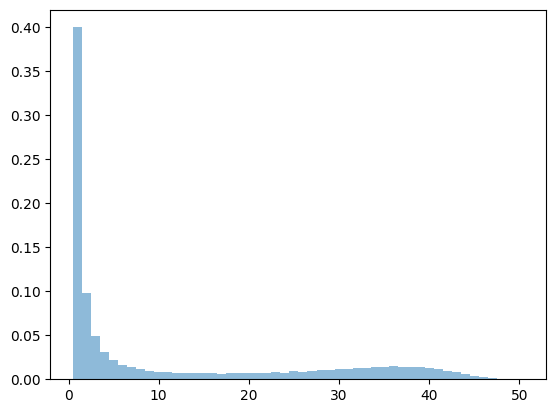

In [ ]:
import numpy as np

def solve_q_forward_real(N, mu):
    """
    Real-valued solver for q_1,...,q_N in:
        1 = sum_{l=1}^M q_l c_{M,l},   M=1..N
    with
        c_{M,l} = mu((M-1)/(N-1))^{-l} * prod_{j=1}^{l-1} (M-j)/(N-j)

    Parameters
    ----------
    N : int
        System size.
    mu : callable
        PGF mu(x). Should return real values for x in [0,1].

    Returns
    -------
    q : np.ndarray shape (N,), dtype float
    """
    if N < 1:
        raise ValueError("N must be >= 1")

    q = np.zeros(N, dtype=float)


    if N == 1:
        mu0 = mu(0.0)
        if mu0 == 0.0:
            raise ZeroDivisionError("mu(0)=0 => c_{1,1} undefined")
        # 1 = q1 * mu(0)^(-1)  => q1 = mu(0)
        q[0] = mu0
        return q

    for M in range(1, N + 1):
        xM = (M - 1) / (N - 1)
        muM = mu(xM)
        if muM == 0.0:
            raise ZeroDivisionError(f"mu({xM})=0 => coefficients undefined for M={M}")

        # prod_{j=1}^{l-1} (M-j)/(N-j), starting at l=1 is 1
        prod = 1.0

        # sum_{l=1}^{M-1} q_l c_{M,l}
        s = 0.0
        for l in range(1, M):
            cMl = (muM ** (-l)) * prod
            s += q[l - 1] * cMl
            prod *= (M - l) / (N - l)

        cMM = (muM ** (-M)) * prod
        if cMM == 0.0:
            raise ZeroDivisionError(f"c_{{{M},{M}}}=0 => cannot solve (check mu, N)")
        q[M - 1] = (1.0 - s) / cMM

    return q




def mu(x, beta, gamma):
    return (gamma/(beta+gamma)) * (1/(1 - (beta/(beta+gamma))*x))

N=50
q = solve_q_forward_real(N, lambda x: mu(x, 4.5, 3))

ell = np.arange(1, N + 1)
#plt.plot(ell, q)
plt.bar(
    ell,                 # integer centers
    q,                   # probabilities q_ell
    width=1.0,           # same unit-width bins
    align='center',
    alpha=0.5,
    label='Theory'
)

This works reasonably well (and matches simulation), but numerical precision issues arise if $N$ gets too large.  Using a few tricks we can extend $N$ further by using higher precision and turning the products into logarithms which can be used to prevent repeated multiplication of very small numbers.  

However, there is a fundamental problem when $N$ gets large and "epidemics" separate out from "small outbreaks".  To find the probability of the larger outbreak sizes by this method, we need to find the probability of all smaller sizes.  Once epidemics and small outbreaks separate, the intermediate sizes are are extremely rare, so $q_\ell$ in this range will be subject to lots of round-off errors, which prevents accurate calculation of the probabilities of the epidemic sizes.

That said, the key benefit of the Ball matrices is that they allow us to study small $N$ settings.  So difficulty at large $N$ is not such an issue.

The code below works for slightly larger $N$ but it is still limited.

<BarContainer object of 100 artists>

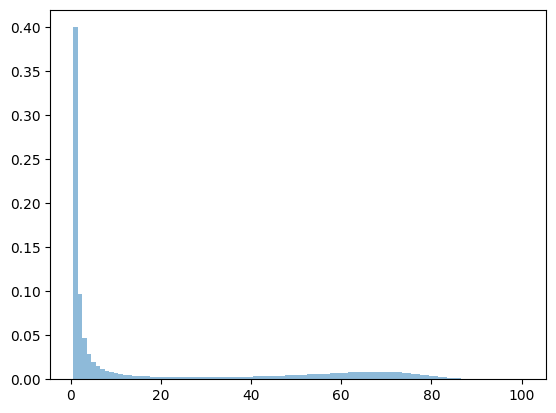

In [ ]:
import numpy as np
import mpmath as mp

def solve_q_forward_mp(N, mu, dps=80):
    """
    High-precision solver for q_1..q_N (real case) using mpmath.

    Solves:
        1 = sum_{l=1}^M q_l c_{M,l},   M=1..N
    with
        c_{M,l} = mu((M-1)/(N-1))^{-l} * prod_{j=1}^{l-1} (M-j)/(N-j)

    Parameters
    ----------
    N : int
    mu : callable returning real (float or mp.mpf) for x in [0,1]
    dps : int
        Decimal digits of precision to use.

    Returns
    -------
    q : list of mp.mpf, length N
    """
    mp.mp.dps = dps
    q = [mp.mpf('0') for _ in range(N)]

    if N == 1:
        mu0 = mp.mpf(mu(mp.mpf('0')))
        if mu0 == 0:
            raise ZeroDivisionError("mu(0)=0")
        q[0] = mu0
        return q

    for M in range(1, N + 1):
        xM = mp.mpf(M - 1) / mp.mpf(N - 1)
        muM = mp.mpf(mu(xM))
        if muM <= 0:
            raise ValueError(f"Need mu({xM})>0 for log-based mp solver; got {muM}")
        log_muM = mp.log(muM)

        # Build logc_l for l=1..M using mp.loggamma
        # logA = log((M-1)!/(M-l)!) - log((N-1)!/(N-l)!)
        logc = []
        for l in range(1, M + 1):
            log_num = mp.loggamma(M) - mp.loggamma(M - l + 1)
            log_den = mp.loggamma(N) - mp.loggamma(N - l + 1)
            logA = log_num - log_den
            logc_l = -mp.mpf(l) * log_muM + logA
            logc.append(logc_l)

        # row scaling
        s = max(logc)
        w = [mp.e**(lc - s) for lc in logc]    # w_l = c_l / exp(s)
        rhs_scaled = mp.e**(-s)               # because sum q_l w_l = exp(-s)

        if M == 1:
            q[0] = rhs_scaled / w[0]
        else:
            partial = mp.fsum(q[l-1] * w[l-1] for l in range(1, M))
            q[M-1] = (rhs_scaled - partial) / w[M-1]

    return q

def mu(x, beta, gamma):
    return (gamma/(beta+gamma)) * (1/(1 - (beta/(beta+gamma))*x))

N=100
q = solve_q_forward_mp(N, lambda x: mu(x, 4.5, 3))

ell = np.arange(1, N + 1)
#plt.plot(ell, q)
plt.bar(
    ell,                 # integer centers
    q,                   # probabilities q_ell
    width=1.0,           # same unit-width bins
    align='center',
    alpha=0.5,
    label='Theory'
)
plt.legend()
plt.show()


## Extension
For fixed $M$, as $N$ gets large, $q_M$ must converge to the result of previous section $\frac{1}{M} [x^{M-1}] \mu(x)^M$, because they are solving the same thing.  I looked at it years ago, but didn't manage to find a direct proof.  I would particuarly like to be able to estimate the magnitue of the error.

I have some ideas how a proof of this might work.  